### This project is for a Cinema Company and the aim is to analyse past data and predict sales based on the data using Time Series Analysis utilising the **Seasonal Autoregressive Differencing Moving Average (SARIMA)** model.
#### The Data was gotten from [Kaggle](https://www.kaggle.com/datasets) and the company is assumed to be a cinema company: 'Silverbird Cinemas'

#### Python Libraries needed to be installed include:
- Pandas
- Matplotlib
- Statsmodels

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from time import time
import warnings
warnings.filterwarnings('ignore')
register_matplotlib_converters()

In [81]:
# Augmented Dicky Fuller Test to check for stationarity of data
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: {}'.format(result[0]))
    print(f'p-value: {result[1]:.50f}')

# Ticket Sales Data for Silverbird Cinemas

In [82]:
# The Company past data is loaded into Jupyter Notebook
ticket_sales = pd.read_csv("Ticket Sales.csv")

In [83]:
#The datetime datatype cast into the data which was previously a string
ticket_sales.Date = pd.to_datetime(ticket_sales.Date)
ticket_sales.info() #Inspect the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    324 non-null    datetime64[ns]
 1   Total   324 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


In [84]:
ticket_sales = ticket_sales.set_index('Date')

#### What the data looks like

In [85]:
ticket_sales

,Total
Date,
1998-01-01,9034
1998-02-01,9596
1998-03-01,10558
1998-04-01,9002
1998-05-01,9239
...,...
2024-08-01,14442
2024-09-01,13422
2024-10-01,13795


In [86]:
start_date = datetime(2008,1,1)
end_date = datetime(2012,1,1)
lim_ticket_sales = ticket_sales.loc[start_date:end_date]
ticket_sales.index

DatetimeIndex(['1998-01-01', '1998-02-01', '1998-03-01', '1998-04-01',
               '1998-05-01', '1998-06-01', '1998-07-01', '1998-08-01',
               '1998-09-01', '1998-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Date', length=324, freq=None)

In [36]:
# limited_ticket_sales = ticket_sales.loc[start_date:end_date]

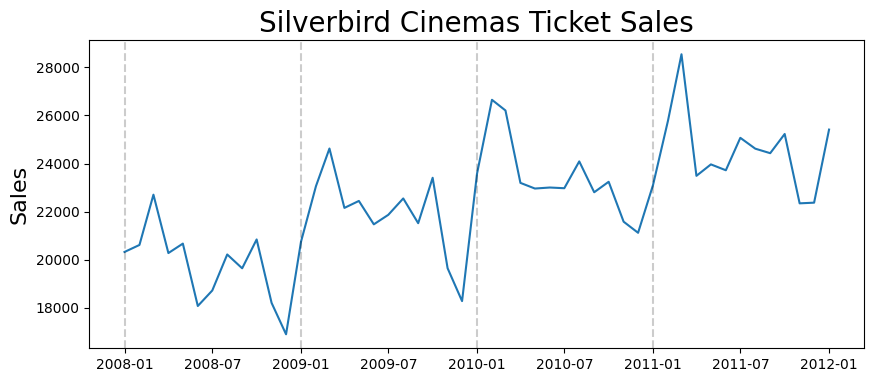

In [88]:
plt.figure(figsize=(10,4))
plt.plot(limited_ticket_sales)
plt.title('Silverbird Cinemas Ticket Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend component to induce stationarity by finding the difference one(1) time

In [91]:
first_diff = limited_ticket_sales.diff()[1:]

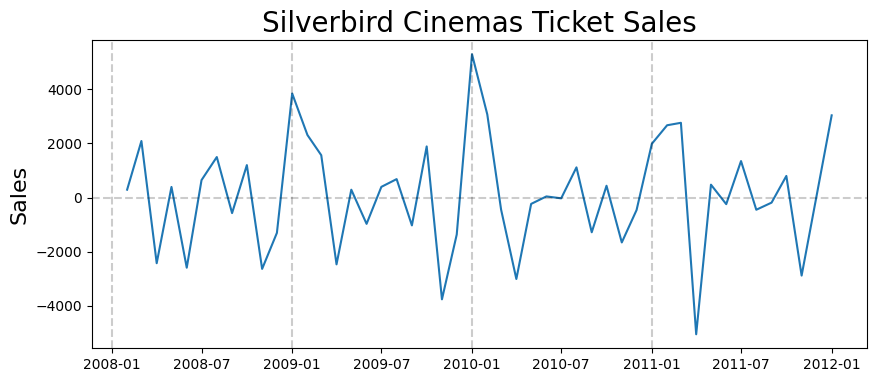

In [92]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Silverbird Cinemas Ticket Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)
plt.show()

In [40]:
perform_adf_test(first_diff)
# It has a very low P Value, therefore, it is stationary and a model can be used on it.

ADF Statistic: -9.515038694170046
p-value: 0.00000000000000031738387006263070974833157893443577


# ACF

<BarContainer object of 17 artists>

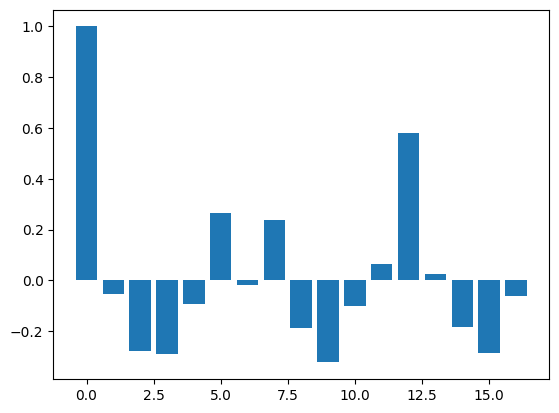

In [93]:
acf_vals = acf(first_diff)
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

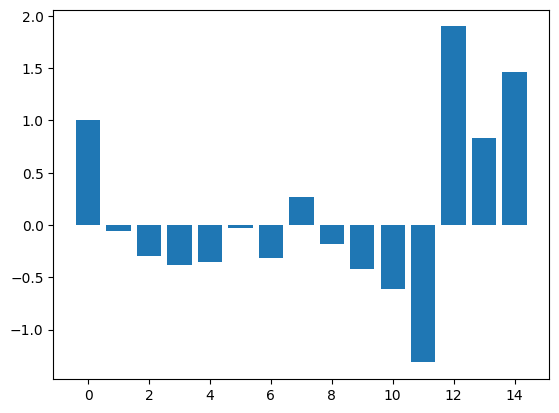

In [94]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [95]:
train_end = datetime(2011,7,1)
test_end = datetime(2012,1,1)

train_data = limited_ticket_sales[:train_end]
test_data = limited_ticket_sales[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model Using the Rolling Forecast Origin

In [96]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = limited_ticket_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions.loc[train_end] = pred[0]

In [97]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

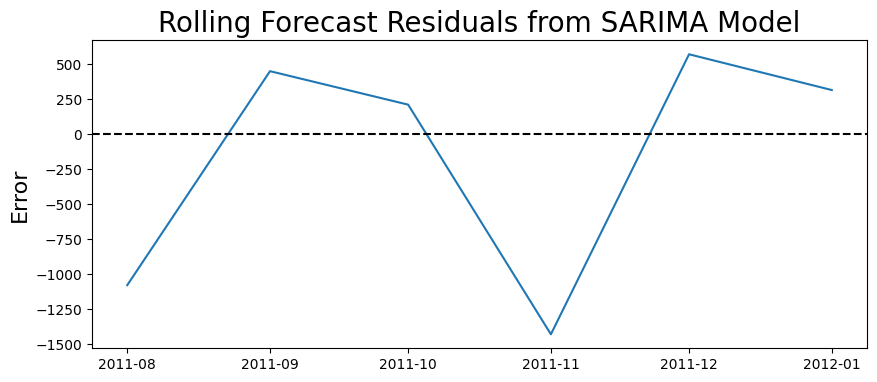

In [98]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

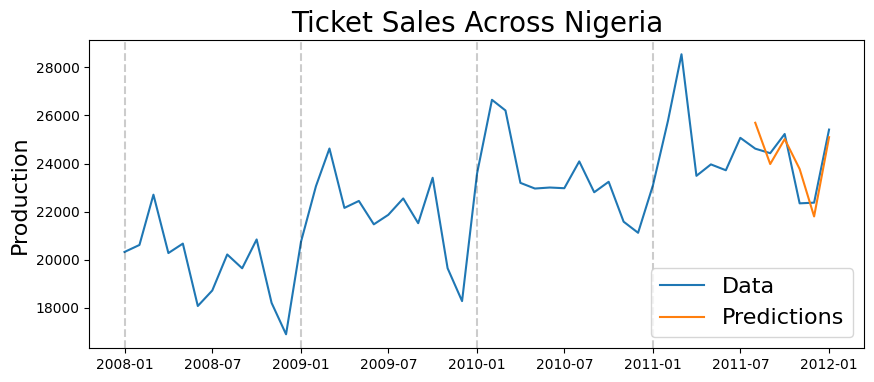

In [99]:
plt.figure(figsize=(10,4))

plt.plot(limited_ticket_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)                                

plt.title('Ticket Sales Across Nigeria', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [100]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0288


### Mean Absolute Percent Error(MAPE)
#### Value Given MAPE = 0.0288 or 2.88%

### - Interpretation:
#### A MAPE of 2.88% means that, on average, the model's predictions are about 2.88% off from the actual values.

A lower MAPE indicates better model accuracy. For many practical scenarios:

- MAPE<10%: Highly accurate
- 10%≤MAPE<20%: Good
- 20%≤MAPE<50%: Acceptable
- MAPE≥50%: Poor

## In this case, our model has a MAPE score of 2.88% which is excellent and suggests that the model performs very well.

In [101]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 804.0874742520025


### Root Mean Squared Error (RMSE)
#### Interpretation:
RMSE measures the average magnitude of prediction errors in the same unit as the dependent variable (y).
Unlike **MAPE, RMSE** penalizes larger errors more heavily due to squaring the differences.
The interpretation of RMSE depends on the scale of the target variable. For instance:
If the target values range between 0 and 10,000, an RMSE of 804 might be acceptable.

## In this case, our model has an RMSE of 804 in a scale of 0 - 28,000 which is excellent and suggests that the model performs very well.

# Since we have predicted the datam